In [115]:
## Notebook to develop toy model of dynamics to be used as input simulator to a constrained generative model. 
## Dynamics are given by a ball that is subject to gravity and moves around in 2d. 

In [116]:
## List of imports (keep it simple)
import numpy as np
import scipy 
from scipy.integrate import odeint
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import subprocess

In [117]:
## List of parameters
dim = 2 #dimensionality of the problem
g = 9.8 #m/(s^2) (gravitational constant)
d = 32 # size of a square enclosure
t = 40 # time to simulate for
dt = 100000
env_params = {'dimension':dim,'grav_constant':g,'enclosure_size':d,'simtime':t,'timesteps':dt}


A = np.zeros((4,4))
A[2,0] = 1
A[3,1] = 1 ## dynamics matrix
e = 1 ## reduction in force 

dyn_params = {'grav_constant':g,'dyn_matrix':A,'elasticity':e}

m = 10.0 # mass of ball
r = 10.0 # radius of ball

ball_params = {'mass':m,'radius':r}




In [118]:
## In order to set up numerical integration, we need a callable function that calculates derivatives of the movement
## as a set of first order differential equations. Thus we define the following

## Define a form on forces as an external effect (we need a form that will return a value for non-integer evaluated 
## points in t):

def ball(y,t,env_params,dyn_params,ball_params,F):
    
    # Define Effect of forces
    # We have the forces determined as Fx and Fy, a sequence that the input gets to see
    # Determine effect of forces:
    F_vec = np.zeros((4))
    F_vec[3] -= dyn_params['grav_constant']*ball_params['mass'] ## Effect of gravity
    F_vec[2:4] += F(t) ## Deterministic exterior force being applied
    
    ## We want elasticity: 
    if np.any(abs(y[0:2])>env_params['enclosure_size']):
        F_imp = dyn_params['elasticity']*(abs(y[0:2])>env_params['enclosure_size'])*100000 ## Bounce back
        F_elast = F_imp*-np.sign(y[0:2])
    else:
        F_elast = np.zeros((2))
    
    F_vec[2:4] += F_elast
    
    ## F = ma
    a_vec = F_vec/ball_params['mass']
    
    ## Write down the full dynamics equation:
    ydot = np.dot(y,dyn_params['dyn_matrix'])+F_vec

    return ydot



In [119]:
## Solve for given F,y0,t
# F = lambda t: np.array([10*np.sin(t),200*np.cos(t)])
F = lambda t: np.array([10*np.sin(t),0])
# F = lambda t: np.array([0,0])
y0 = np.zeros((4))
y0[1]+=20
t = np.linspace(0,env_params['simtime'],env_params['timesteps'])
sol = odeint(ball, y0, t, args=(env_params,dyn_params,ball_params,F))

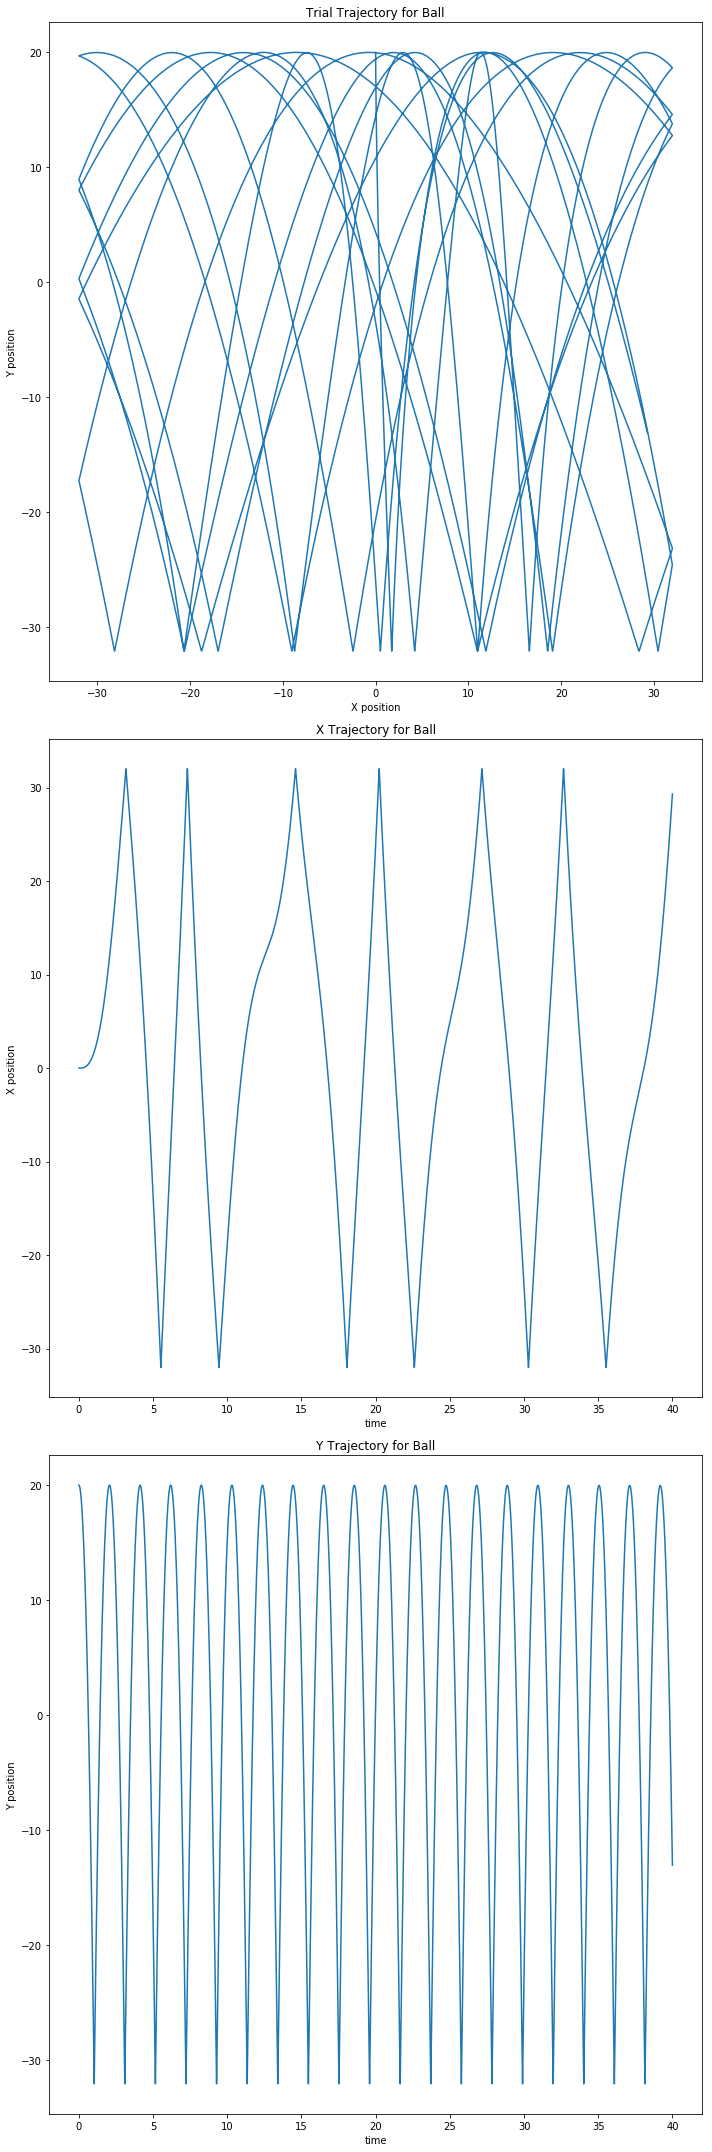

In [120]:
fig,ax = plt.subplots(3,1,figsize = (10,30))
ax[0].plot(sol[:,0],sol[:,1])
ax[0].set_title('Trial Trajectory for Ball')
ax[0].set_xlabel('X position')
ax[0].set_ylabel('Y position')
ax[1].plot(t,sol[:,0])
ax[1].set_title('X Trajectory for Ball')
ax[1].set_xlabel('time')
ax[1].set_ylabel('X position')
ax[2].plot(t,sol[:,1])
ax[2].set_title('Y Trajectory for Ball')
ax[2].set_xlabel('time')
ax[2].set_ylabel('Y position')
plt.tight_layout()
plt.show()

In [121]:
# Render a background (static for now)
background = (np.random.rand(2*env_params['enclosure_size']+1,2*env_params['enclosure_size']+1,3))

In [122]:
# Generate frames for a video:
videodirectory = 'toydynamics'
try:
    os.mkdir(videodirectory)
except:
    print('Directory already exists!')

# Sample at the seconds timescale:
frames = np.linspace(0,env_params['timesteps']-1,30*env_params['simtime']).astype('int')
print('Generating Frames')

# Preprocess 
sol[sol>31.5]=31.5
sol[sol<-31.5]=-31.5
for i,ti in enumerate(frames):
    if i == 94:
        print(sol[ti,0]+32,-sol[ti,1]+32)
    fig,ax = plt.subplots(figsize = (5,5))
    ax.imshow(background)
    ax.plot(sol[ti,0]+32,-sol[ti,1]+32,'ro',markersize=ball_params['radius'])
    ax.axis('off')
    plt.savefig(videodirectory+'/'+'frame%03d.png'%i)
    plt.close()
os.chdir(videodirectory)
print("Generating video")
subprocess.call(['ffmpeg', '-framerate', str(30), '-i', 'frame%03d.png', '-r', '30','Video_ball'+'.mp4'])

for file_name in glob.glob("*.png"):
    os.remove('./'+file_name)
os.chdir("../")


Directory already exists!
Generating Frames
(63.296700844859203, 59.93083604385096)
Generating video
